In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from astropy.table import Table
import warnings
warnings.simplefilter("ignore")

import plotly.express as px

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

You can check a burst's GBM detectors by putting its name into the [GRB burst catalog](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermigbrst&Action=More+Options) and selecting the data products option "D".

--- 

- FullCatalog.fits holds ALL GRB sources contained in the 2nd Fermi-LAT GRB Catalog
- RS=null.fits holds GRBs which have a null in the redshift parameter
---

In [3]:
### Helper functions -- always run this cell

def clean_data(targets):
    # Cleans columns & GRB names
    
    # Remove trailing whitespace
    targets = targets.rename(columns=lambda x: x.strip().lower())
    # Cleans GRB names
    targets['name'] = targets['name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)#[1:]
    #targets['gcn_name'] = targets['gcn_name'].str.decode("utf-8").replace('\'','').replace(r"^ +| +$", r"", regex=True)[1:]

    return targets

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

def calculate_hardness(targets):
    # Calculates flux, flux_ene & fluence ratios with corresponding error
    targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
    targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
    targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']
    targets['hardness'] = targets['like_lat_fluence']/targets['like_gbm_fluence']



    targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                                  targets['like_lat_flux'],
                                                  targets['like_gbm_flux_error'],
                                                  targets['like_lat_flux_error'])

    targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                      targets['like_lat_flux_ene'],
                                                      targets['like_gbm_flux_ene_error'],
                                                      targets['like_lat_flux_ene_error'])

    targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                      targets['like_lat_fluence'],
                                                      targets['like_gbm_fluence_error'],
                                                      targets['like_lat_fluence_error'])
    
    targets['hardness_error'] = propagate_error(targets['like_lat_fluence'],
                                                targets['like_gbm_fluence'],
                                                targets['like_lat_fluence_error'],
                                                targets['like_gbm_fluence_error'])
    return targets

def calculate_time_difference(targets):
    # Calculate like & gbm-lle time differences
    targets['like_gbm-lat_time_difference'] = targets['like_gbm_t0'] - targets['like_lat_t0']
    targets['gbm-lle_t90_difference'] = targets['gbm_cat_t90'] - targets['lle_t90']
    return targets

def calculate_ratio(targets):
    # T90/T50 ratio + propagated error
    # Only have T90/T50 for GBM which is fine, cause apparently LAT has lc index anyway
    targets['gbm_t9050'] = targets['t90']/targets['t50']
    targets['gbm_t9050_error'] = propagate_error(targets['t90'], targets['t50'], targets['t90_error'], targets['t50_error'])
    return targets

In [4]:
# Load the datasets
LAT = Table.read('./LATCatalog.fits').to_pandas()
GBM = Table.read('./GBMCatalog.fits').to_pandas()

LAT = clean_data(LAT)
GBM = clean_data(GBM)

# Calculate ratio for GBM
GBM = calculate_ratio(GBM)

# Merge datasets
all_candidates = pd.merge(left = LAT, right = GBM, on = 'name', how = 'left')

# Calculate merge ratios
all_candidates = calculate_hardness(all_candidates)
all_candidates = calculate_time_difference(all_candidates)

all_candidates.T.tail(12).T.describe()

,gbm_t9050,gbm_t9050_error,flux_ratio,flux_ene_ratio,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference
count,220.0,220.000000,223.0,223.0,223.0,223.0,157.0,157.0,157.0,157.0,231.0,231.0
unique,213.0,220.000000,159.0,159.0,159.0,159.0,143.0,143.0,143.0,143.0,222.0,226.0
top,2.0,0.198272,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,0.0,60.0
freq,6.0,1.000000,58.0,58.0,58.0,58.0,15.0,15.0,15.0,15.0,8.0,3.0


In [5]:
cols = ['name', 'hardness', 'hardness_error', 't90', 'lle_t90', 'gbm_t9050', 'gbm_t9050_error', 'lat_spl_index1', 'lat_spl_index1_error']
#all_candidates[cols].info()
all_candidates.query('redshift == 0').dropna(subset = ['gbm_t9050']).query('hardness > 1')

,name,gcn_name,time,trigger_met,ra_x,dec_x,lii_x,bii_x,error_radius_x,redshift,...,flux_ratio,flux_ene_ratio,fluence_ratio,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference
0,GRB140323433,b'GRB140323A ',56739.432558,4.172630e+08,356.520,-79.920,306.4554,-36.7570,0.180,0.0,...,0.000000,0.000000,0.000000,inf,NaN,NaN,NaN,NaN,-226.80000,111.426
1,GRB190731943,b'GRB190731A ',58695.943322,5.863055e+08,340.310,-76.420,312.1918,-38.2711,0.310,0.0,...,4.471796,1.431112,0.082395,12.136621,2.782806,1.239458,0.071361,10.511273,1.73200,9.518
2,GRB160325291,b'GRB160325A ',57472.291215,4.805820e+08,16.210,-72.660,301.5342,-44.4319,0.240,0.0,...,5.683414,12.483589,0.345712,2.892581,2.596723,6.898600,0.191046,0.883345,-2.93200,42.742
4,GRB201104001,b'GRB201104A ',59157.000648,6.261409e+08,81.370,-71.130,282.0331,-32.4744,0.240,0.0,...,1.142307,1.189541,0.818288,1.222063,0.486710,0.652436,0.448812,0.679326,-0.26000,45.251
6,GRB171212434,b'GRB171212B ',58099.433542,5.347671e+08,39.420,-70.630,291.0416,-43.9636,0.430,0.0,...,0.000000,0.000000,0.000000,inf,NaN,NaN,NaN,NaN,-116.62000,32.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,GRB151006413,b'GRB151006A ',57301.413160,4.658181e+08,147.426,70.504,140.9229,39.6632,0.001,0.0,...,4.082982,4.082988,0.369536,2.706097,0.000000,0.000000,0.000000,0.000000,-13.66311,77.301
222,GRB130502327,b'GRB130502B ',56414.327211,3.891739e+08,66.650,70.830,138.8486,14.9548,0.320,0.0,...,17.296672,12.823209,0.239119,4.182019,7.685688,9.667731,0.180278,3.193325,-5.21200,22.757
223,GRB170728961,b'GRB170728B ',57962.960637,5.229758e+08,237.430,70.850,105.5221,39.6976,1.010,0.0,...,3.473132,2.072392,0.204717,4.884793,1.638372,1.943580,0.191992,4.730537,-0.21000,45.926
224,GRB081224887,b'GRB81224.0 ',54824.887442,2.518463e+08,201.100,72.670,119.5155,44.2389,0.330,0.0,...,4.991271,4.991272,0.312521,3.199781,0.000000,0.000000,0.000000,0.000000,-75.77400,16.448


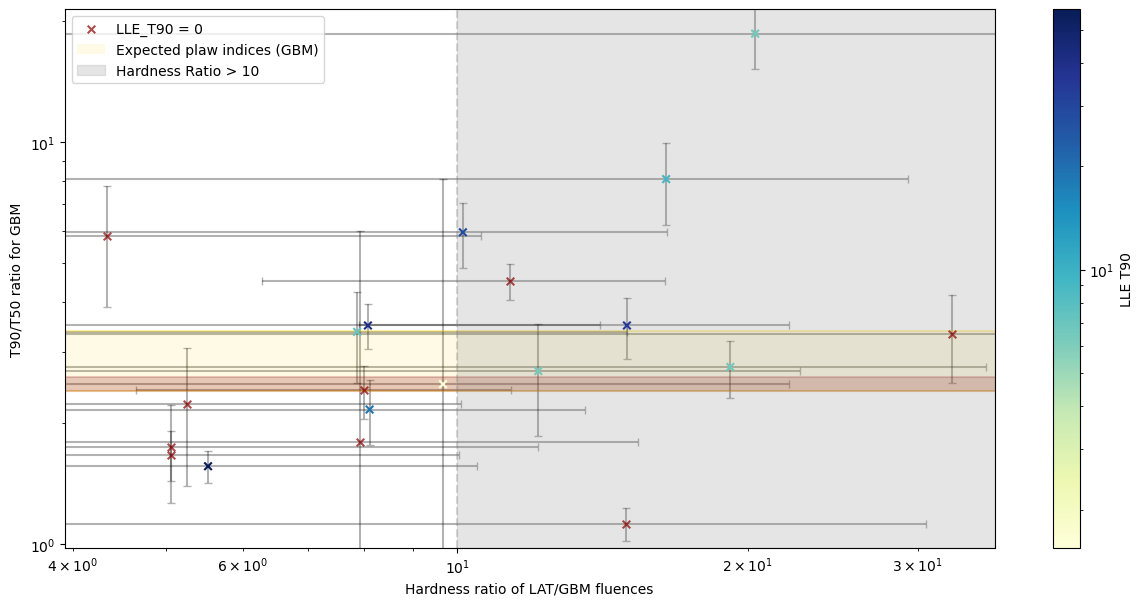

In [6]:
all_candidates['hardness_upper'] = all_candidates['hardness'] + all_candidates['hardness_error']

# Only unassociated candidates
candidates = all_candidates.query('redshift == 0').dropna(subset = ['gbm_t9050'])
candidates = candidates.query('hardness_upper >= 10') # Enforce that hardness_upper-bound > 10

fig, ax = plt.subplots()

# Plot the candidates with color by LAT T90
sx = ax.scatter(candidates['hardness'], candidates['gbm_t9050'], marker = 'x', \
    c=(candidates['lle_t90']), cmap='YlGnBu', norm=matplotlib.colors.LogNorm(), \
    s=30, zorder = 3)
fig.colorbar(sx, ax = ax, label = 'LLE T90', orientation = 'vertical')

# Re-plot the candidates with 'infinite' hardness i.e. invisible to GBM
# We skip the candidates with 0 hardness because our models show that a source MUST have LAT appear BEFORE GBM
_ = candidates.query('lle_t90 == 0')
ax.scatter(_['hardness'], _['gbm_t9050'], color='darkred', marker='x', s=30, \
    label = f'LLE_T90 = 0', alpha=.7, zorder = 4)


ax.set_yscale('log')
ax.set_xscale('log')
# Save the lims before we apply the errorbar (since the errorbars stretch the lims a ton)
xl = fig.gca().get_xlim()
yl = fig.gca().get_ylim()

# Apply errorbars
ax.errorbar(candidates['hardness'], candidates['gbm_t9050'], \
    xerr = candidates['hardness_error'], yerr = candidates['gbm_t9050_error'], \
    fmt='none', linewidth=1.5, capsize=3, \
    color='black', markersize=3, alpha=.3, zorder = 1)


# Show expected limits for each of the variables
#ax.axhspan(.35, .52, facecolor='gold', alpha=.1, label = 'Indices .35 to .52', zorder = 2)
ax.axhspan(2.4, 3.4, facecolor='gold', alpha=.1, zorder = 2, label = 'Expected plaw indices (GBM)')
#ax.axhspan(.37, .52, facecolor='darkred', alpha=.2, label = 'Predicted range', zorder = 2)
ax.axhspan(2.4, 2.6, facecolor='darkred', alpha=.2, zorder = 2)
# Just outline those spans
# ax.axhline(.35, color = 'gold', alpha = .3, zorder = 2)
# ax.axhline(.52, color = 'gold', alpha = .3, zorder = 2)
ax.axhline(2.4, color = 'gold', alpha = .3, zorder = 2)
ax.axhline(3.4, color = 'gold', alpha = .3, zorder = 2)
# ax.axhline(.37, color = 'darkred', alpha = .2, zorder = 2)
# ax.axhline(.52, color = 'darkred', alpha = .2, zorder = 2)
ax.axhline(2.4, color = 'darkred', alpha = .2, zorder = 2)
ax.axhline(2.6, color = 'darkred', alpha = .2, zorder = 2)

ax.axvline(10, linestyle = '--', color = 'grey', zorder = 2, alpha = .3)
ax.axvspan(10, max(xl), color = 'grey', alpha = .2, zorder = 2, label = 'Hardness Ratio > 10')

# Reset plot limits
ax.set_xlim(xl)
ax.set_ylim(yl)
ax.set_ylabel('T90/T50 ratio for GBM')
ax.set_xlabel('Hardness ratio of LAT/GBM fluences')
ax.legend()

# names = ['GRB150702998', 'GRB091120191', 'GRB171210493', 'GRB110120666', 'GRB130325203']
# for name in names:
#     it = all_candidates.loc[ all_candidates['name'] == name].iloc[0]
#     ax.plot(it['gbm_t9050'], it['lle_t90'], color = 'C0', \
#         marker = '.', markerfacecolor = 'none', markersize = 30, zorder = 5)

# top_3 = candidates.query('hardness_upper > 14.6 & hardness < 40.3').query('gbm_cat_t90 > 50')
# ax.errorbar(top_3['gbm_cat_t90'], top_3['hardness'], 
# yerr = top_3['hardness_error'], 
# fmt='o', linewidth=1.5, capsize=3,
# color='darkred', markersize=3, label = 'Preliminary top 3')



# # Estimated hardness
# """
# NaI
# lower=14.6
# higher=40.3
# BGO
# lower=1.2
# higher=3.36
# """
# ax.axhline(40.3, linestyle='-', color='darkred', alpha=.4)#, label='Expected LAT/NaI hardness, upper')
# ax.axhline(14.6, linestyle='-.', color='darkred', alpha=.4)#, label='Expected LAT/NaI hardness, lower')
# ax.axhspan(14.6, 40.3, facecolor='darkred', alpha=.1, label ='Expected LAT/NaI hardness')

# ax.axhline(3.36, linestyle='-', color='blue', alpha=.4)#, label='Expected LAT/BGO hardness, upper')
# ax.axhline(1.2, linestyle='-.', color='blue', alpha=.4)#, label='Expected LAT/BGO hardness, lower')
# ax.axhspan(1.2, 3.36, facecolor='blue', alpha=.1, label = 'Expected LAT/BGO hardness')


# # Previous estimation
# ax.axvline(0.1, linestyle='--',  label = r'Previous search: $\tau$ = 0.1s', color='black', alpha=.4)

# # GBM energies
# ax.axvline(252, linestyle='--',  label = r'GBM BGO 1MeV', color='orange', alpha=.4)
# ax.axvline(267, linestyle='-.',  label = r'GBM BGO 8keV', color='orange', alpha=.4)
# ax.axvline(284, linestyle='-',  label = r'GBM NaI 200keV', color='orange', alpha=.4)
# ax.axvline(183, linestyle='-',  label = r'LAT 20MeV', color='green', alpha=.4)

# ax.axvspan(252, 284, color='orange', alpha=.1)

# ax.legend()

# plt.figtext(0.5, -0.05, 'Hardness values of infinity are the darkest red color as shown in the legend -- all others are mapped to the right-hand colorbar.\n' + \
#     'The yellow highlight shows all values which are possible for both detectors;\n' + \
#     'the red shows the predicted values for either the corresponding GBM or LAT metric only.\n' + \
#     'Blue circles denote the candidates whose error allows them to lie within the yellow overlap.', \
#     wrap=True, horizontalalignment='center', fontsize=10)

#ax.set_title('GBM T90 vs. Hardness upper-bound')

fig.set_figwidth(15)
fig.set_figheight(7)
#fig.savefig('Ratio+Index+Hardness.png', dpi=500)
fig.show()

In [7]:
candidates['gbm_t9050_upper_bound'] = candidates['gbm_t9050'] + candidates['gbm_t9050_error']
candidates['gbm_t9050_lower_bound'] = candidates['gbm_t9050'] - candidates['gbm_t9050_error']

# str = ''
# for name in candidates.query('gbm_t9050_upper_bound > 2.4 & gbm_t9050_lower_bound < 3.4').name:
#     str += '%s OR '%name
# print(str[:-3])

candidates.query('gbm_t9050_upper_bound > 2.4 & gbm_t9050_lower_bound < 3.4').sort_values(by='like_gbm_ts')

,name,gcn_name,time,trigger_met,ra_x,dec_x,lii_x,bii_x,error_radius_x,redshift,...,hardness,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,hardness_error,like_gbm-lat_time_difference,gbm-lle_t90_difference,hardness_upper,gbm_t9050_upper_bound,gbm_t9050_lower_bound
152,GRB180210517,b'GRB180210A ',58159.517107,5.399583e+08,1.830,18.490,108.5329,-43.1449,0.120,0.0,...,8.016764,4.585010,3.317481,0.080781,3.362132,-18.964,38.913,11.378896,2.777012,2.048509
208,GRB120915000,b'GRB120915A ',56185.000474,3.693600e+08,240.950,57.040,88.0620,44.9119,1.760,0.0,...,7.932213,0.332156,0.114388,0.111673,7.465616,-0.550,0.576,15.397829,6.029122,-2.429122
34,GRB220408311,b'GRB220408B ',59677.311157,6.710957e+08,92.480,-50.970,258.8511,-27.0772,0.060,0.0,...,32.573197,6.949773,1.359339,0.029807,31.307608,-6.624,32.513,63.880805,4.159884,2.524533
11,GRB180703876,b'GRB180703A ',58302.876157,5.523445e+08,6.560,-67.100,306.7281,-49.8421,0.330,0.0,...,7.877799,13.478790,8.985856,0.115725,7.117189,-2.304,13.619,14.994988,4.232524,2.517476
83,GRB181028590,b'GRB181028A ',58419.590069,5.624286e+08,88.922,-21.981,227.3435,-21.6821,0.306,0.0,...,5.248896,0.278362,0.143487,0.161529,4.833115,-24.632,29.697,10.082011,3.067836,1.393853
47,GRB190531840,b'GRB190531B ',58634.840417,5.810262e+08,24.390,-41.950,273.4221,-72.4336,0.100,0.0,...,19.184728,3.062354,1.327302,0.043558,16.132658,-6.240,31.443,35.317386,3.210816,2.307847
1,GRB190731943,b'GRB190731A ',58695.943322,5.863055e+08,340.310,-76.420,312.1918,-38.2711,0.310,0.0,...,12.136621,2.782806,1.239458,0.071361,10.511273,1.732,9.518,22.647894,3.538089,1.853215
131,GRB140402007,b'GRB140402A ',56749.007014,4.180902e+08,207.660,5.970,339.2299,64.5844,0.160,0.0,...,9.669260,71.324275,31.082109,0.139030,12.399470,-0.238,-1.226,22.068729,8.086347,-3.086347
89,GRB210928084,b'GRB210928A ',59485.083692,6.544872e+08,245.776,-17.999,357.6673,21.6837,0.120,0.0,...,8.116773,4.608649,1.892793,0.082957,5.447874,-9.950,4.790,13.564647,2.556373,1.769208
44,GRB150523396,b'GRB150523A ',57165.395694,4.540662e+08,115.340,-45.430,258.6739,-10.9449,0.080,0.0,...,8.083893,6.791340,6.650011,0.089496,5.984489,-2.088,41.956,14.068383,3.947508,3.052577


Text(0.5, 1.0, 'LAT T90 for hardness = infty')

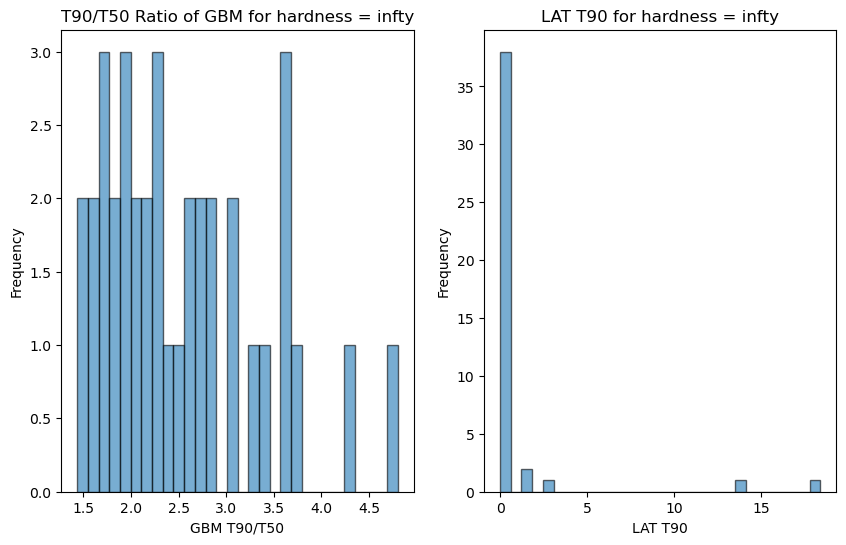

In [8]:
fig, axes = plt.subplots(1,2,figsize = (10,6))

args = {'bins': 30, 'edgecolor': 'black', 'alpha': 0.6}

ax = axes[0]
inf = np.infty
_ = all_candidates.query('hardness == @inf & redshift == 0')

ax.hist(_['gbm_t9050'], **args)
#ax.set_yscale('log')
# _[['lle_t90', 'hardness', 'gbm_t9050']]

ax.set_ylabel('Frequency')
ax.set_xlabel('GBM T90/T50')
ax.set_title('T90/T50 Ratio of GBM for hardness = infty')

ax = axes[1]
ax.hist(_['lle_t90'], **args)

ax.set_ylabel('Frequency')
ax.set_xlabel('LAT T90')
ax.set_title('LAT T90 for hardness = infty')

In [9]:
#all_candidates.query('gbm_t9050 < 5 & gbm_t9050 > 2.5 & lat_spl_index1 < .3 & lat_spl_index1 > 0')
names = ['GRB150702998', 'GRB091120191', 'GRB171210493', 'GRB110120666', 'GRB130325203']
all_candidates.query('name in @names')[cols]

,name,hardness,hardness_error,t90,lle_t90,gbm_t9050,gbm_t9050_error,lat_spl_index1,lat_spl_index1_error
26,GRB150702998,inf,NaN,45.825,0.000,3.086274,0.621502,0.437732,0.270027
84,GRB091120191,0.563264,0.196673,50.177,0.000,2.390292,0.795860,0.539140,0.089459
87,GRB130325203,3.171399,3.017822,6.912,0.000,3.000000,1.527455,0.129019,0.323275
97,GRB110120666,1.946726,1.138517,26.173,0.231,4.089531,1.246899,0.552345,0.416720
160,GRB171210493,0.785526,0.331079,143.107,8.200,3.249994,0.420814,0.653730,0.275319


------

Hardness > 1
GBM T90 in []

In [8]:
selected_candidates = all_candidates.query('redshift == 0 & hardness > 1').query(
     '(gbm_cat_t90 > 200 & gbm_cat_t90 < 350) | (lle_t90 < 200 & lle_t90 > 30)'
)

unassoc_hard_candidates = all_candidates.query('redshift == 0 & hardness > 1')
unassoc_hard_candidates['hardness_upper'] = unassoc_hard_candidates['hardness'] + unassoc_hard_candidates['hardness_error']

There are a bunch of quirks in this dataset:
- There are 'infinite' hardnesses. This is because the GBM fluence was registered as 0.
- A bunch of the sources are lle_t90 = 0. This accounts for 

In [9]:

print('Total unassociated sources: %s'%unassoc_hard_candidates.shape[0])

print( 'N. sources with lle_t90 = 0.: %s'%unassoc_hard_candidates.query('lle_t90==0').shape[0])

inf = np.infty
print( 'N. sources with infinite hardness: %s'% unassoc_hard_candidates.query('hardness == @inf').shape[0])
print( 'N. sources that are lle_t90 = 0. AND have infinite hardness: %s'%unassoc_hard_candidates.query('lle_t90==0 & hardness==@inf').shape[0])


print('N. sources with GBM t90=0.: %s'%unassoc_hard_candidates.query('gbm_cat_t90 == 0').shape[0])

Total unassociated sources: 138
N. sources with lle_t90 = 0.: 77
N. sources with infinite hardness: 43
N. sources that are lle_t90 = 0. AND have infinite hardness: 37
N. sources with GBM t90=0.: 0


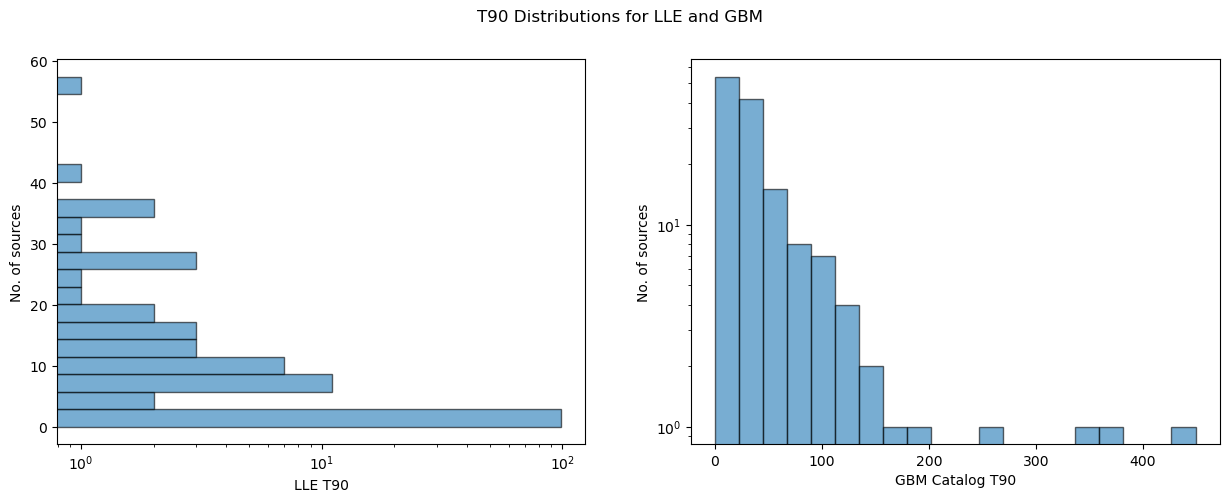

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].hist(unassoc_hard_candidates['lle_t90'], alpha = 0.6, edgecolor='black', bins=20, orientation='horizontal')
ax[0].set_xscale('log')
ax[0].set_xlabel('LLE T90')
ax[0].set_ylabel('No. of sources')

ax[1].hist(unassoc_hard_candidates['gbm_cat_t90'], alpha = 0.6, edgecolor='black', bins=20)
ax[1].set_yscale('log')
ax[1].set_xlabel('GBM Catalog T90')
ax[1].set_ylabel('No. of sources')

fig.suptitle('T90 Distributions for LLE and GBM')

fig.set_figwidth(15)
fig.set_figheight(5)
fig.show()

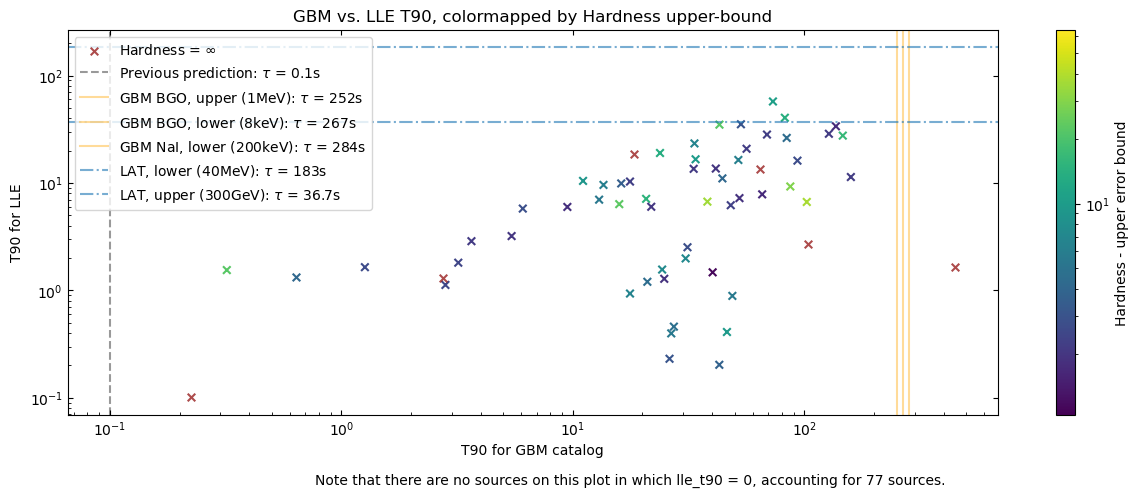

In [11]:
fig, ax = plt.subplots()

# Scatter plot all objects.
sx = ax.scatter(unassoc_hard_candidates['gbm_cat_t90'], unassoc_hard_candidates['lle_t90'], marker = 'x', c=(unassoc_hard_candidates['hardness_upper']),
 s=30, cmap='viridis', norm=matplotlib.colors.LogNorm())
fig.colorbar(sx, ax=ax, label = 'Hardness - upper error bound', orientation = 'vertical')

# Include the objects with 'infinite' hardness.
inf = np.infty
_ = unassoc_hard_candidates.query('hardness == @inf')
ax.scatter(_['gbm_cat_t90'], _['lle_t90'], color='darkred', marker='x', s=30, label = f'Hardness = $\infty$', alpha=.7)

# Previous estimation
ax.axvline(0.1, linestyle='--',  label = r'Previous prediction: $\tau$ = 0.1s', color='black', alpha=.4)

# GBM energies
ax.axvline(252, linestyle='-',  label = r'GBM BGO, upper (1MeV): $\tau$ = 252s', color='orange', alpha=.4)
ax.axvline(267, linestyle='-',  label = r'GBM BGO, lower (8keV): $\tau$ = 267s', color='orange', alpha=.4)
ax.axvline(284, linestyle='-',  label = r'GBM NaI, lower (200keV): $\tau$ = 284s', color='orange', alpha=.4)

# LAT energies
ax.axhline(183, linestyle='-.',  label = r'LAT, lower (40MeV): $\tau$ = 183s', alpha=.6)
ax.axhline(36.7, linestyle='-.',  label = r'LAT, upper (300GeV): $\tau$ = 36.7s', alpha=.6)

# Labels
ax.set_ylabel('T90 for LLE')
ax.set_xlabel('T90 for GBM catalog')

# Log scale
ax.set_xscale('log')
ax.set_yscale('log')

# x, yticks on inside & on top/right
ax.tick_params(axis="x", bottom=True, top=True)
ax.tick_params(axis="y", left=True, right=True)
ax.tick_params(axis="both", which="both", direction="in")

plt.figtext(0.5, -0.03, 'Note that there are no sources on this plot in which lle_t90 = 0, accounting for 77 sources.', wrap=True, horizontalalignment='center', fontsize=10)

fig.set_figwidth(15)
fig.set_figheight(5)
ax.legend()

ax.set_title('GBM vs. LLE T90, colormapped by Hardness upper-bound')

fig.show()

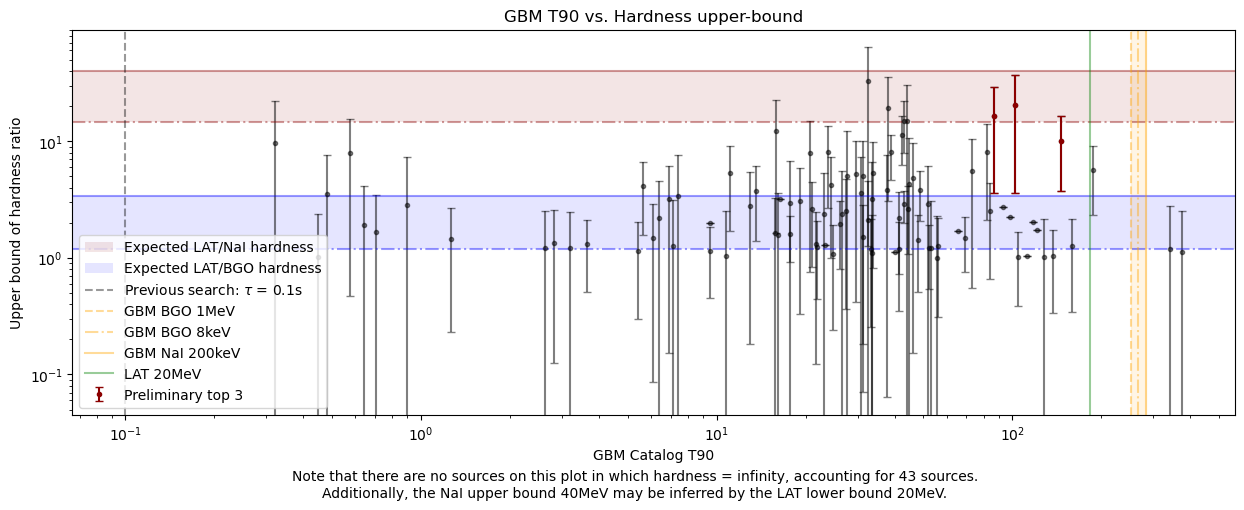

In [203]:
# In that spirit, let's focus mainly on the GBM T90.

fig, ax = plt.subplots()

#ax.scatter(unassoc_hard_candidates['gbm_cat_t90'], unassoc_hard_candidates['hardness_upper'], marker='x', color='black', s=20)
ax.errorbar(unassoc_hard_candidates['gbm_cat_t90'], unassoc_hard_candidates['hardness'], 
yerr = unassoc_hard_candidates['hardness_error'], 
fmt='o', linewidth=1.5, capsize=3,
color='black', markersize=3, alpha=.5)

top_3 = unassoc_hard_candidates.query('hardness_upper > 14.6 & hardness < 40.3').query('gbm_cat_t90 > 50')
ax.errorbar(top_3['gbm_cat_t90'], top_3['hardness'], 
yerr = top_3['hardness_error'], 
fmt='o', linewidth=1.5, capsize=3,
color='darkred', markersize=3, label = 'Preliminary top 3')


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('GBM Catalog T90')
ax.set_ylabel('Upper bound of hardness ratio')

# Estimated hardness
"""
NaI
lower=14.6
higher=40.3
BGO
lower=1.2
higher=3.36
"""
ax.axhline(40.3, linestyle='-', color='darkred', alpha=.4)#, label='Expected LAT/NaI hardness, upper')
ax.axhline(14.6, linestyle='-.', color='darkred', alpha=.4)#, label='Expected LAT/NaI hardness, lower')
ax.axhspan(14.6, 40.3, facecolor='darkred', alpha=.1, label ='Expected LAT/NaI hardness')

ax.axhline(3.36, linestyle='-', color='blue', alpha=.4)#, label='Expected LAT/BGO hardness, upper')
ax.axhline(1.2, linestyle='-.', color='blue', alpha=.4)#, label='Expected LAT/BGO hardness, lower')
ax.axhspan(1.2, 3.36, facecolor='blue', alpha=.1, label = 'Expected LAT/BGO hardness')


# Previous estimation
ax.axvline(0.1, linestyle='--',  label = r'Previous search: $\tau$ = 0.1s', color='black', alpha=.4)

# GBM energies
ax.axvline(252, linestyle='--',  label = r'GBM BGO 1MeV', color='orange', alpha=.4)
ax.axvline(267, linestyle='-.',  label = r'GBM BGO 8keV', color='orange', alpha=.4)
ax.axvline(284, linestyle='-',  label = r'GBM NaI 200keV', color='orange', alpha=.4)
ax.axvline(183, linestyle='-',  label = r'LAT 20MeV', color='green', alpha=.4)

ax.axvspan(252, 284, color='orange', alpha=.1)

ax.legend()

plt.figtext(0.5, -0.05, 'Note that there are no sources on this plot in which hardness = infinity, accounting for 43 sources.\n'+\
'Additionally, the NaI upper bound 40MeV may be inferred by the LAT lower bound 20MeV.',
 wrap=True, horizontalalignment='center', fontsize=10)

ax.set_title('GBM T90 vs. Hardness upper-bound')

fig.set_figwidth(15)
fig.set_figheight(5)
fig.savefig('GBM_vs_Hardness.png')
fig.show()

In [202]:
str = '['
for name in top_3.name:
    str += '"%s", '%name
str[:-2] + ']'

'["GRB130821674", "GRB140206275", "GRB100116897"]'

--------

In [4]:
selected_candidates = all_candidates.query('redshift == 0 & hardness > 1').query(
     '(gbm_cat_t90 > 200 & gbm_cat_t90 < 350) | (lle_t90 < 200 & lle_t90 > 30)'
)

px.scatter(selected_candidates, x='gbm_cat_t90', y='lle_t90', color='hardness')

In [7]:
all_candidates['log_hardness'] = np.log(all_candidates['hardness'])
fig = px.scatter(all_candidates.query('redshift == 0 & hardness > 1'), x='gbm_cat_t90', y='lle_t90', color='log_hardness', log_y=True, log_x=True)
fig